# Hedging Models Test - GBM Data

This notebook tests all hedging models on GBM-generated data:

1. **Data Generation**: Generate price paths using Geometric Brownian Motion
2. **Model Testing**: Test all deep and non-deep hedging models
3. **Visualization**: Plot GBM paths, delta positions, premiums, and evaluation metrics
4. **Evaluation**: Compute replication error and other relevant statistics


In [1]:
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pathlib import Path

project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

from src.models.parametric.gbm import GeometricBrownianMotion
from src.utils.preprocessing_utils import LogReturnTransformation

# Import deep hedgers
from src.hedging_models.deep_hedgers.feedforward_layers import FeedforwardLayers
from src.hedging_models.deep_hedgers.feedforward_time import FeedforwardTime
from src.hedging_models.deep_hedgers.lstm_hedger import LSTM
from src.hedging_models.deep_hedgers.rnn_hedger import RNN

# Import non-deep hedgers
from src.hedging_models.non_deep_hedgers.black_scholes import BlackScholes
from src.hedging_models.non_deep_hedgers.delta_gamma import DeltaGamma
from src.hedging_models.non_deep_hedgers.linear_regression import LinearRegression
from src.hedging_models.non_deep_hedgers.xgboost import XGBoost

print("Imports successful!")

Imports successful!


## Step 1: Generate GBM Data


In [2]:
num_train_samples = 10000
num_test_samples = 2000
seq_length = 99
strike = 1.0
initial_price = 1.0
seed = 0

gbm = GeometricBrownianMotion()
dummy_log_returns = torch.randn(100, 20) * 0.02
gbm.fit(dummy_log_returns)

print(f"GBM Parameters:")
print(f"  mu (drift): {gbm.mu.item():.6f}")
print(f"  sigma (volatility): {gbm.sigma.item():.6f}")

train_log_returns = gbm.generate(num_train_samples, seq_length, seed=seed)
test_log_returns = gbm.generate(num_test_samples, seq_length, seed=seed + 1000)

print(f"\nGenerated data shapes:")
print(f"  Train log returns: {train_log_returns.shape}")
print(f"  Test log returns: {test_log_returns.shape}")

transformer = LogReturnTransformation()

train_prices = []
for i in range(num_train_samples):
    initial_val = torch.tensor(initial_price)
    prices = transformer.inverse_transform(train_log_returns[i], initial_val)
    train_prices.append(prices)
train_prices = torch.stack(train_prices)

test_prices = []
for i in range(num_test_samples):
    initial_val = torch.tensor(initial_price)
    prices = transformer.inverse_transform(test_log_returns[i], initial_val)
    test_prices.append(prices)
test_prices = torch.stack(test_prices)

print(f"\nPrice data shapes:")
print(f"  Train prices: {train_prices.shape}")
print(f"  Test prices: {test_prices.shape}")
print(f"  Price range: [{train_prices.min():.4f}, {train_prices.max():.4f}]")

mu: 0.0002459026873111725, sigma: 0.019809624180197716
GBM Parameters:
  mu (drift): 0.000246
  sigma (volatility): 0.019810

Generated data shapes:
  Train log returns: torch.Size([10000, 99])
  Test log returns: torch.Size([2000, 99])

Price data shapes:
  Train prices: torch.Size([10000, 100])
  Test prices: torch.Size([2000, 100])
  Price range: [0.4965, 2.1288]


## Step 2: Visualize Sample GBM Paths


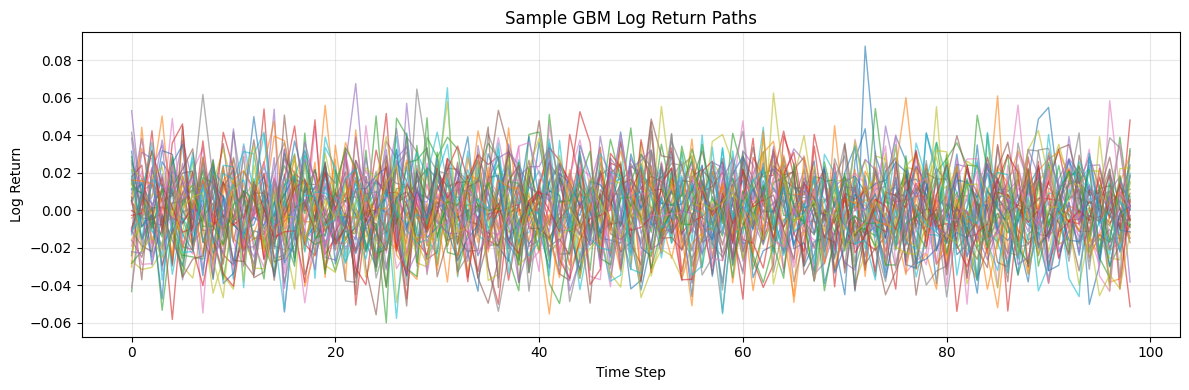

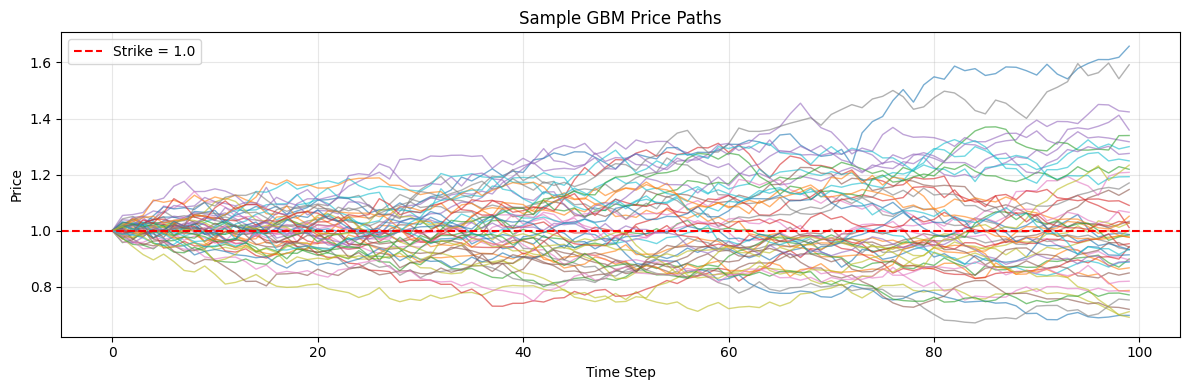

In [3]:
fig_lr, ax_lr = plt.subplots(figsize=(12, 4))
time_steps_lr = np.arange(seq_length)
np.random.seed(42)
sample_indices = np.random.choice(num_train_samples, 50, replace=False)

for idx in sample_indices:
    ax_lr.plot(time_steps_lr, train_log_returns[idx].cpu().numpy(), alpha=0.6, linewidth=1)

ax_lr.set_xlabel('Time Step')
ax_lr.set_ylabel('Log Return')
ax_lr.set_title('Sample GBM Log Return Paths')
ax_lr.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig_price, ax_price = plt.subplots(figsize=(12, 4))
time_steps_price = np.arange(seq_length + 1)
for idx in sample_indices:
    ax_price.plot(time_steps_price, train_prices[idx].cpu().numpy(), alpha=0.6, linewidth=1)

ax_price.axhline(y=strike, color='r', linestyle='--', label=f'Strike = {strike}')
ax_price.set_xlabel('Time Step')
ax_price.set_ylabel('Price')
ax_price.set_title('Sample GBM Price Paths')
ax_price.legend()
ax_price.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 3: Initialize and Train All Hedging Models


In [4]:
# Initialize all models
models = {}

# Deep hedgers
models['FeedforwardLayers'] = FeedforwardLayers(seq_length=seq_length+1, hidden_size=64, strike=strike)
models['FeedforwardTime'] = FeedforwardTime(seq_length=seq_length+1, hidden_size=64, strike=strike)
models['LSTM'] = LSTM(seq_length=seq_length+1, hidden_size=64, strike=strike, num_layers=2)
models['RNN'] = RNN(seq_length=seq_length+1, hidden_size=64, strike=strike, num_layers=2)

# Non-deep hedgers
models['BlackScholes'] = BlackScholes(seq_length=seq_length+1, strike=strike)
models['DeltaGamma'] = DeltaGamma(seq_length=seq_length+1, strike=strike)
models['LinearRegression'] = LinearRegression(seq_length=seq_length+1, strike=strike)
models['XGBoost'] = XGBoost(seq_length=seq_length+1, strike=strike, n_estimators=50, max_depth=7)

print(f"Initialized {len(models)} hedging models:")
for name in models.keys():
    print(f"  - {name}")


Initialized 8 hedging models:
  - FeedforwardLayers
  - FeedforwardTime
  - LSTM
  - RNN
  - BlackScholes
  - DeltaGamma
  - LinearRegression
  - XGBoost


In [5]:
training_results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}")
    
    try:
        if 'Feedforward' in name or 'LSTM' in name or 'RNN' in name:
            model.fit(train_prices, num_epochs=70, batch_size=32, learning_rate=1e-3)
        else:
            model.fit(train_prices)
        
        training_results[name] = "Success"
        print(f"✓ {name} trained successfully")
    except Exception as e:
        training_results[name] = f"Error: {str(e)}"
        print(f"✗ {name} failed: {str(e)}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*60}")
print("Training Summary:")
for name, result in training_results.items():
    status = "✓" if result == "Success" else "✗"
    print(f"  {status} {name}: {result}")



Training FeedforwardLayers
Epoch 1/70, Loss: 0.004489
Epoch 2/70, Loss: 0.000944
Epoch 3/70, Loss: 0.000661
Epoch 4/70, Loss: 0.000346
Epoch 5/70, Loss: 0.000180
Epoch 6/70, Loss: 0.000145
Epoch 7/70, Loss: 0.000120
Epoch 8/70, Loss: 0.000069
Epoch 9/70, Loss: 0.000091
Epoch 10/70, Loss: 0.000061
Epoch 11/70, Loss: 0.000047
Epoch 12/70, Loss: 0.000055
Epoch 13/70, Loss: 0.000064
Epoch 14/70, Loss: 0.000055
Epoch 15/70, Loss: 0.000040
Epoch 16/70, Loss: 0.000043
Epoch 17/70, Loss: 0.000035
Epoch 18/70, Loss: 0.000036
Epoch 19/70, Loss: 0.000032
Epoch 20/70, Loss: 0.000048
Epoch 21/70, Loss: 0.000046
Epoch 22/70, Loss: 0.000030
Epoch 23/70, Loss: 0.000029
Epoch 24/70, Loss: 0.000030
Epoch 25/70, Loss: 0.000029
Epoch 26/70, Loss: 0.000026
Epoch 27/70, Loss: 0.000046
Epoch 28/70, Loss: 0.000032
Epoch 29/70, Loss: 0.000019
Epoch 30/70, Loss: 0.000024
Epoch 31/70, Loss: 0.000046
Epoch 32/70, Loss: 0.000017
Epoch 33/70, Loss: 0.000017
Epoch 34/70, Loss: 0.000137
Epoch 35/70, Loss: 0.000012
E

## Step 4: Evaluate Models on Test Data


In [6]:
# Evaluate all models
evaluation_results = {}

for name, model in models.items():
    if training_results.get(name) != "Success":
        continue
    
    print(f"\nEvaluating {name}...")
    try:
        results = model.evaluate(test_prices)
        evaluation_results[name] = results
        print(f"  Premium: {results['premium']:.6f}")
        print(f"  Mean X (replication error): {results['mean_X']:.6f}")
        print(f"  Std X: {results['std_X']:.6f}")
        print(f"  MSE X: {results['mse_X']:.6f}")
    except Exception as e:
        print(f"  Error: {str(e)}")
        evaluation_results[name] = None

print(f"\n{'='*60}")
print("Evaluation Summary:")
print(f"{'='*60}")



Evaluating FeedforwardLayers...
  Premium: 0.006352
  Mean X (replication error): 0.000039
  Std X: 0.003193
  MSE X: 0.000010

Evaluating FeedforwardTime...
  Premium: 0.015159
  Mean X (replication error): 0.000520
  Std X: 0.006480
  MSE X: 0.000042

Evaluating LSTM...
  Premium: 0.078864
  Mean X (replication error): 0.000196
  Std X: 0.007587
  MSE X: 0.000058

Evaluating RNN...
  Premium: 0.078111
  Mean X (replication error): 0.000736
  Std X: 0.008730
  MSE X: 0.000077

Evaluating BlackScholes...
  Premium: 0.078890
  Mean X (replication error): -0.000132
  Std X: 0.006864
  MSE X: 0.000047

Evaluating DeltaGamma...
  Premium: 0.079656
  Mean X (replication error): -0.040078
  Std X: 0.014875
  MSE X: 0.001827

Evaluating LinearRegression...
  Premium: 0.076447
  Mean X (replication error): 0.000718
  Std X: 0.058074
  MSE X: 0.003371

Evaluating XGBoost...
  Premium: 0.089151
  Mean X (replication error): -0.008971
  Std X: 0.071241
  MSE X: 0.005153

Evaluation Summary:


In [7]:
# Create evaluation summary table
eval_data = []
for name, results in evaluation_results.items():
    if results is not None:
        eval_data.append({
            'Model': name,
            'Premium': results['premium'],
            'Mean_X': results['mean_X'],
            'Std_X': results['std_X'],
            'MSE_X': results['mse_X'],
            'Mean_Payoff': results['mean_payoff'],
            'Mean_Terminal_Value': results['mean_terminal_value']
        })

if eval_data:
    eval_df = pd.DataFrame(eval_data)
    print("\nEvaluation Metrics:")
    print(eval_df.to_string(index=False))



Evaluation Metrics:
            Model  Premium    Mean_X    Std_X    MSE_X  Mean_Payoff  Mean_Terminal_Value
FeedforwardLayers 0.006352  0.000039 0.003193 0.000010     0.094448             0.094408
  FeedforwardTime 0.015159  0.000520 0.006480 0.000042     0.094448             0.093928
             LSTM 0.078864  0.000196 0.007587 0.000058     0.094448             0.094251
              RNN 0.078111  0.000736 0.008730 0.000077     0.094448             0.093712
     BlackScholes 0.078890 -0.000132 0.006864 0.000047     0.094448             0.094580
       DeltaGamma 0.079656 -0.040078 0.014875 0.001827     0.094448             0.134526
 LinearRegression 0.076447  0.000718 0.058074 0.003371     0.094448             0.093730
          XGBoost 0.089151 -0.008971 0.071241 0.005153     0.094448             0.103419


## Step 5: Compare Replication Errors

Computing replication errors for FeedforwardLayers...
Computing replication errors for FeedforwardTime...
Computing replication errors for LSTM...
Computing replication errors for RNN...
Computing replication errors for BlackScholes...
Computing replication errors for DeltaGamma...
Computing replication errors for LinearRegression...
Computing replication errors for XGBoost...


/var/folders/5g/xd1_vnlj2zg4df463t644sgw0000gn/T/ipykernel_12174/1269212686.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(error_data, labels=list(replication_errors.keys()), vert=True)


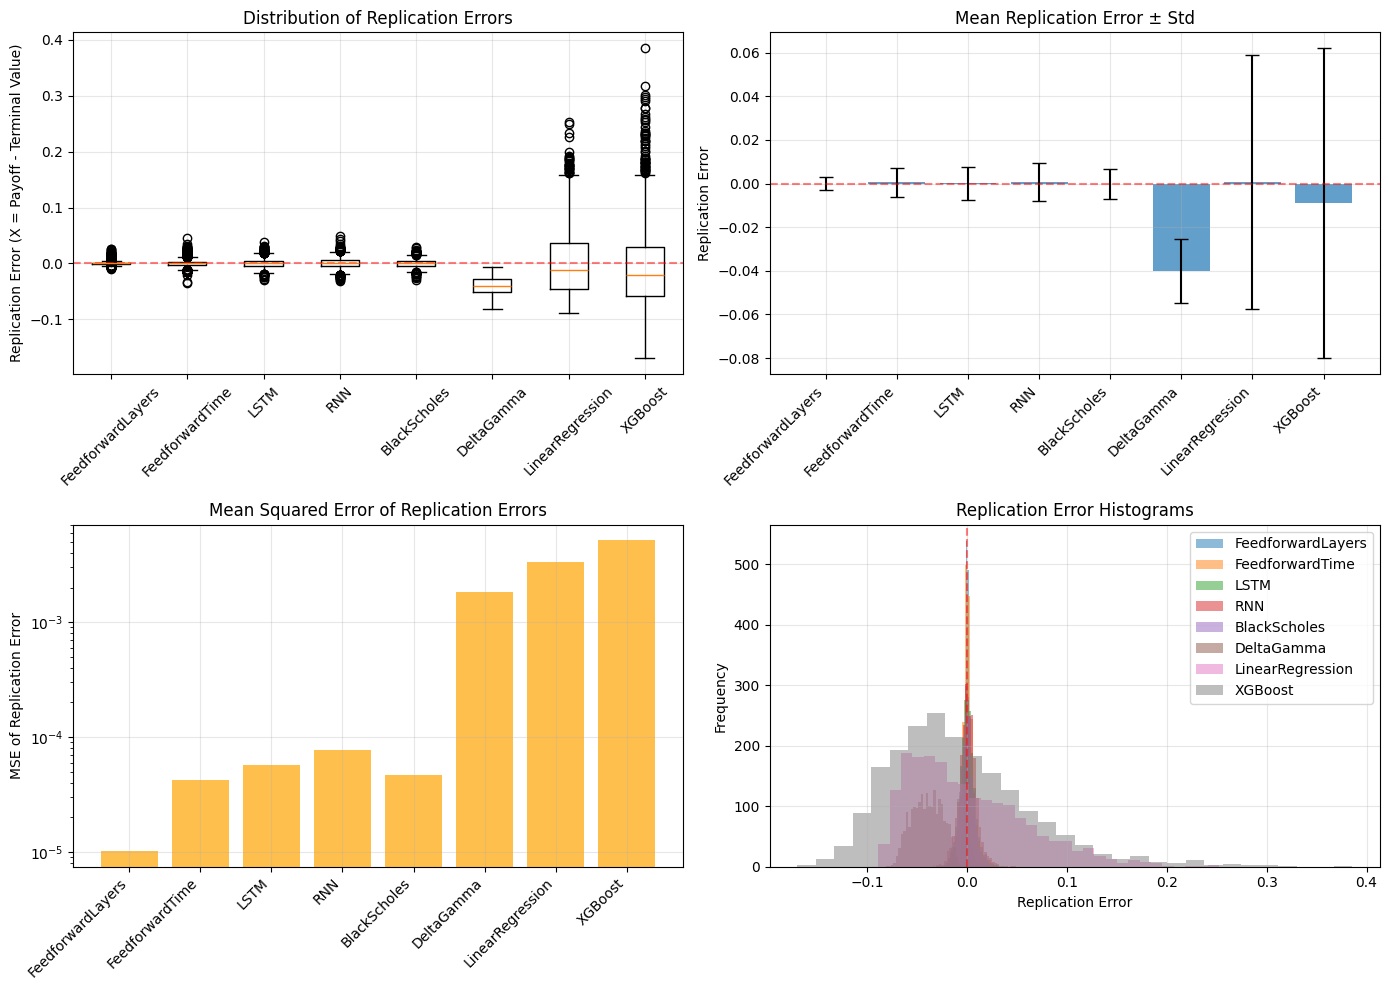

In [10]:
# Compute replication errors for all test samples
replication_errors = {}

for name, model in models.items():
    if name not in evaluation_results or evaluation_results[name] is None:
        continue
    
    print(f"Computing replication errors for {name}...")
    with torch.no_grad():
        deltas = model.forward(test_prices)
        terminal_values = model.compute_terminal_value(test_prices, deltas)
        final_prices = test_prices[:, -1]
        payoffs = model.compute_payoff(final_prices)
        X = payoffs - terminal_values
        replication_errors[name] = X.cpu().numpy()

# Plot replication error distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot 1: Box plot of replication errors
ax1 = axes[0]
error_data = [replication_errors[name] for name in replication_errors.keys()]
ax1.boxplot(error_data, labels=list(replication_errors.keys()), vert=True)
ax1.set_ylabel('Replication Error (X = Payoff - Terminal Value)')
ax1.set_title('Distribution of Replication Errors')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 2: Mean and Std of replication errors
ax2 = axes[1]
means = [np.mean(replication_errors[name]) for name in replication_errors.keys()]
stds = [np.std(replication_errors[name]) for name in replication_errors.keys()]
x_pos = np.arange(len(replication_errors.keys()))
ax2.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(list(replication_errors.keys()), rotation=45, ha='right')
ax2.set_ylabel('Replication Error')
ax2.set_title('Mean Replication Error ± Std')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Plot 3: MSE of replication errors
ax3 = axes[2]
mses = [np.mean(replication_errors[name]**2) for name in replication_errors.keys()]
ax3.bar(x_pos, mses, alpha=0.7, color='orange')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(list(replication_errors.keys()), rotation=45, ha='right')
ax3.set_ylabel('MSE of Replication Error')
ax3.set_title('Mean Squared Error of Replication Errors')
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Histogram comparison for a few models
ax4 = axes[3]
selected_models = list(replication_errors.keys())  # Select first 4
for name in selected_models:
    ax4.hist(replication_errors[name], bins=30, alpha=0.5, label=name)
ax4.set_xlabel('Replication Error')
ax4.set_ylabel('Frequency')
ax4.set_title('Replication Error Histograms')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.axvline(x=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


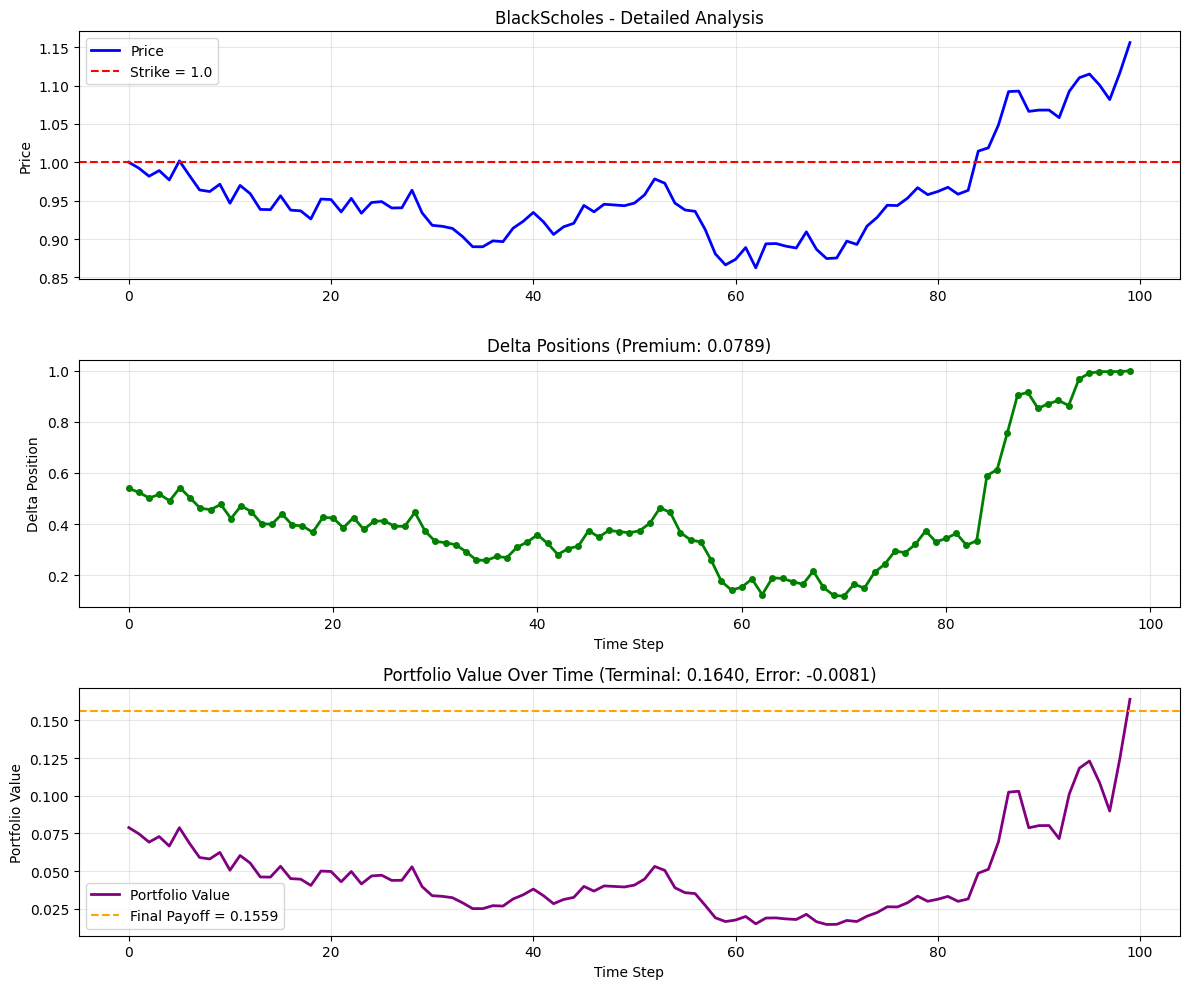

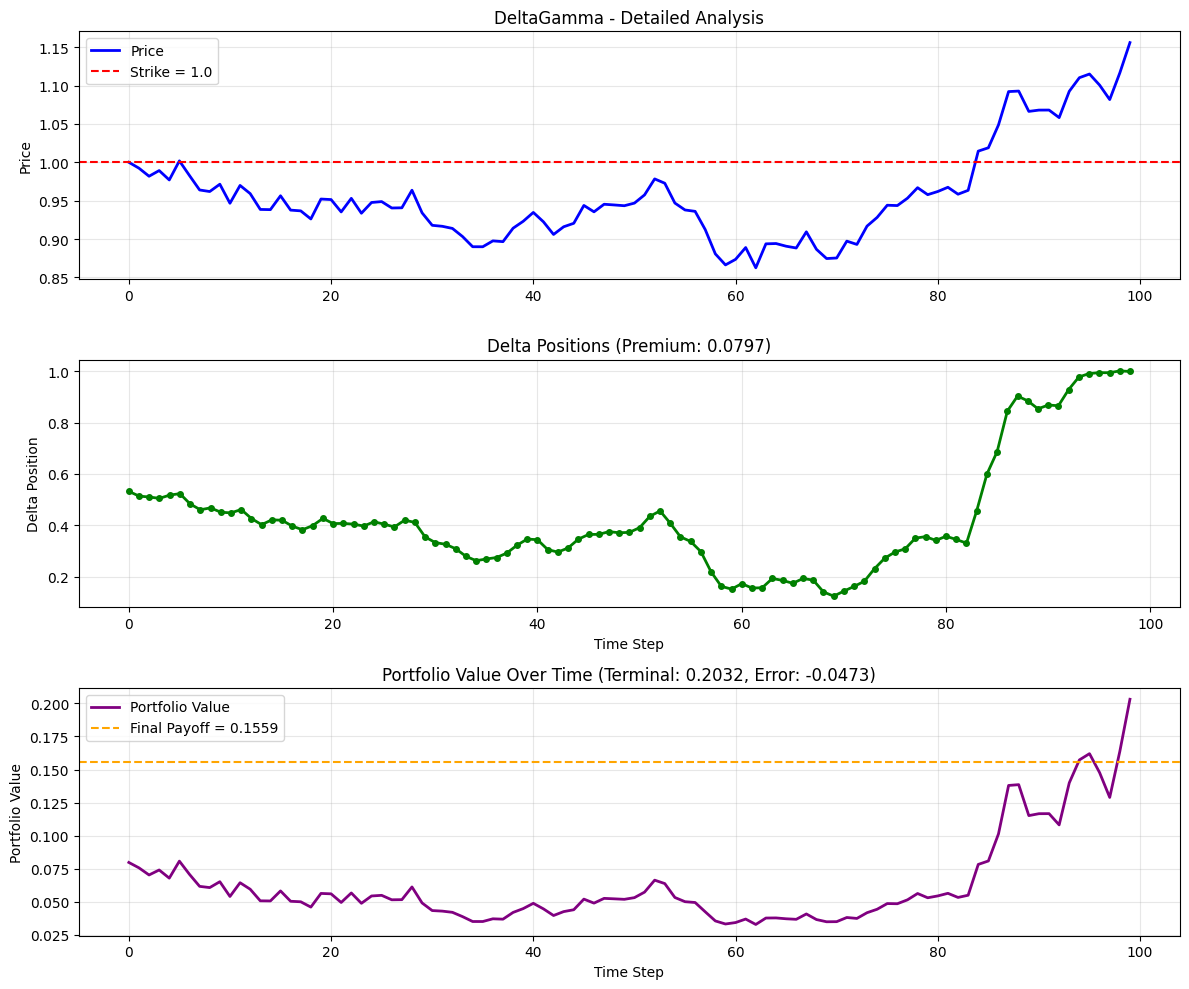

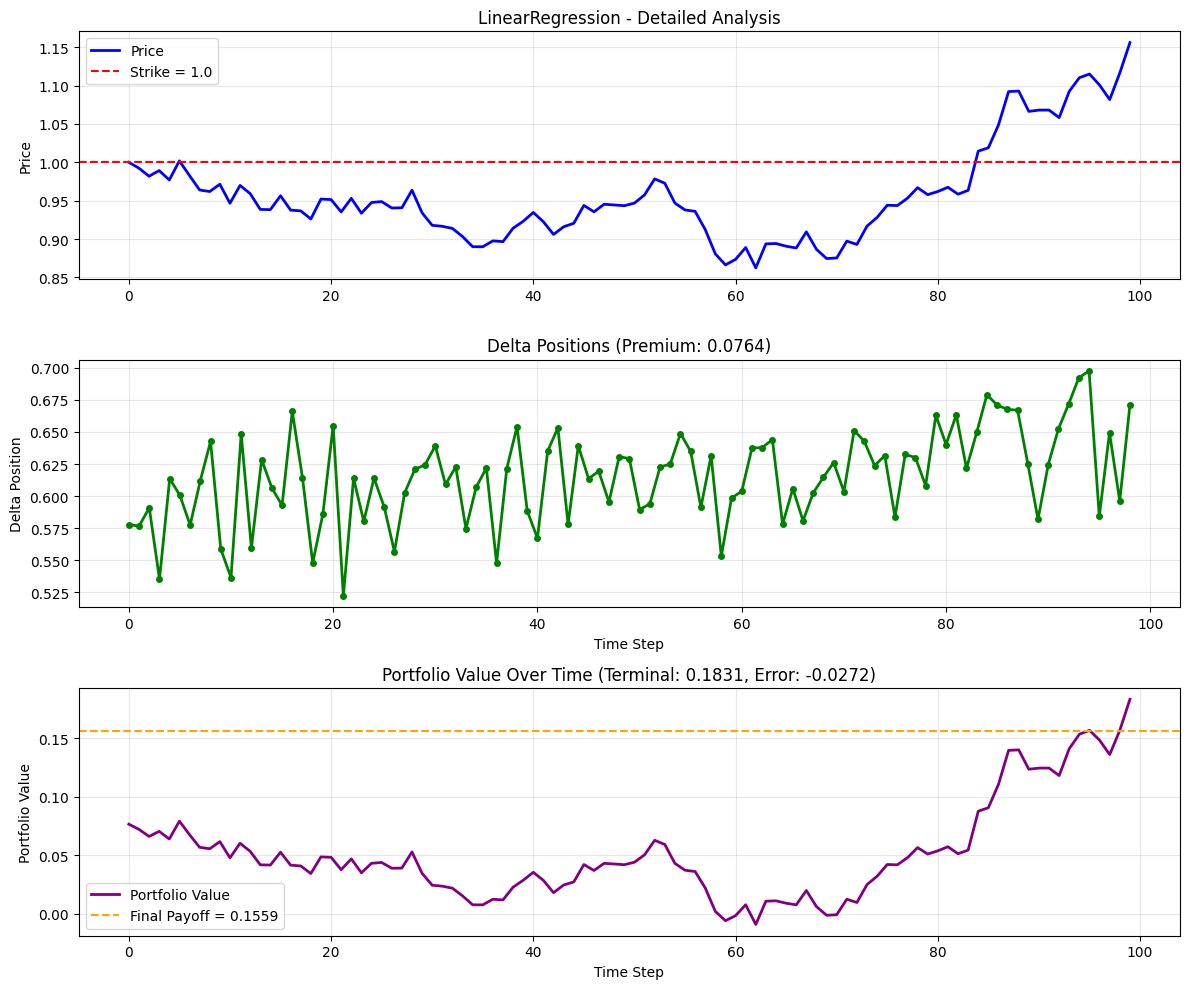

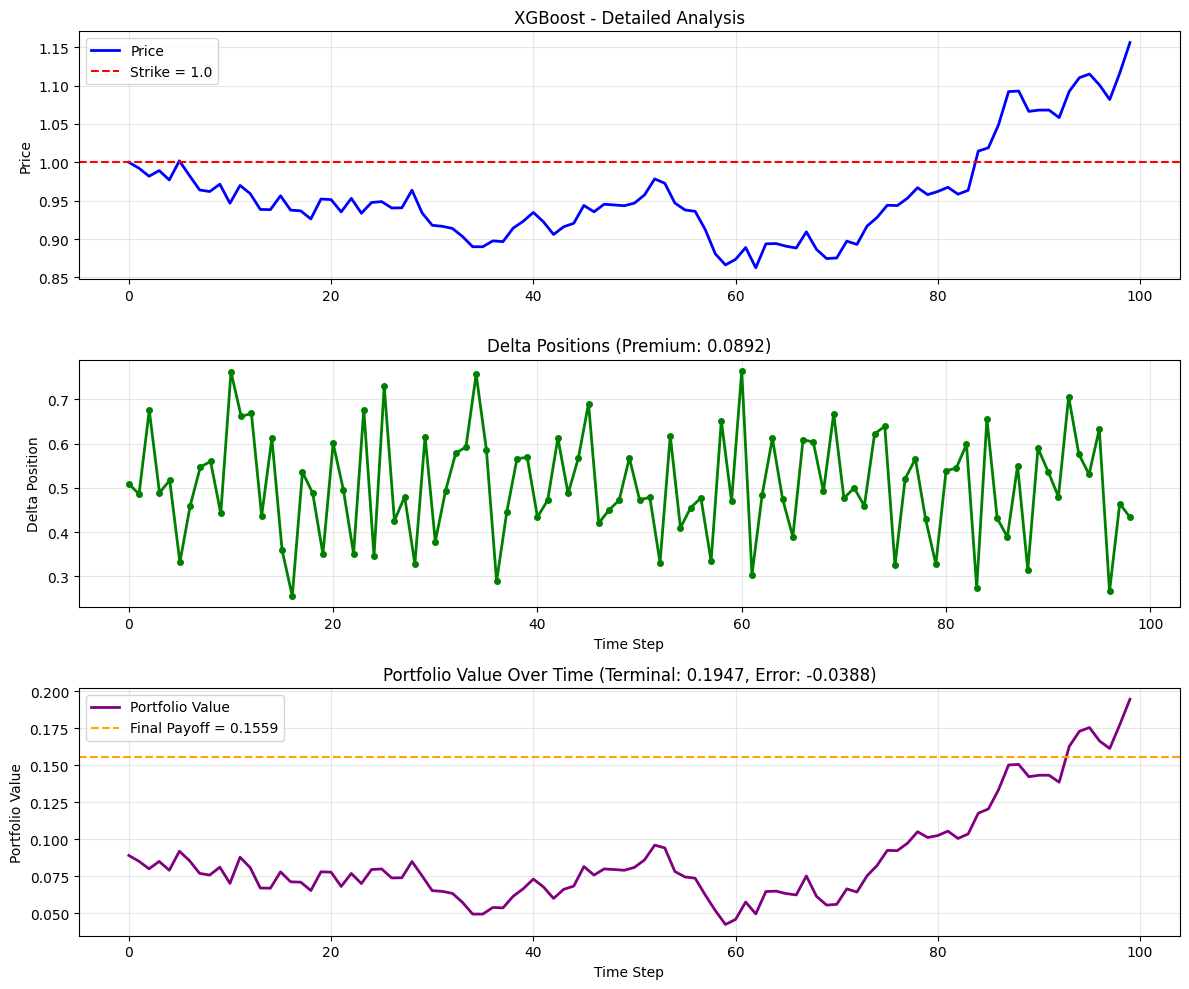

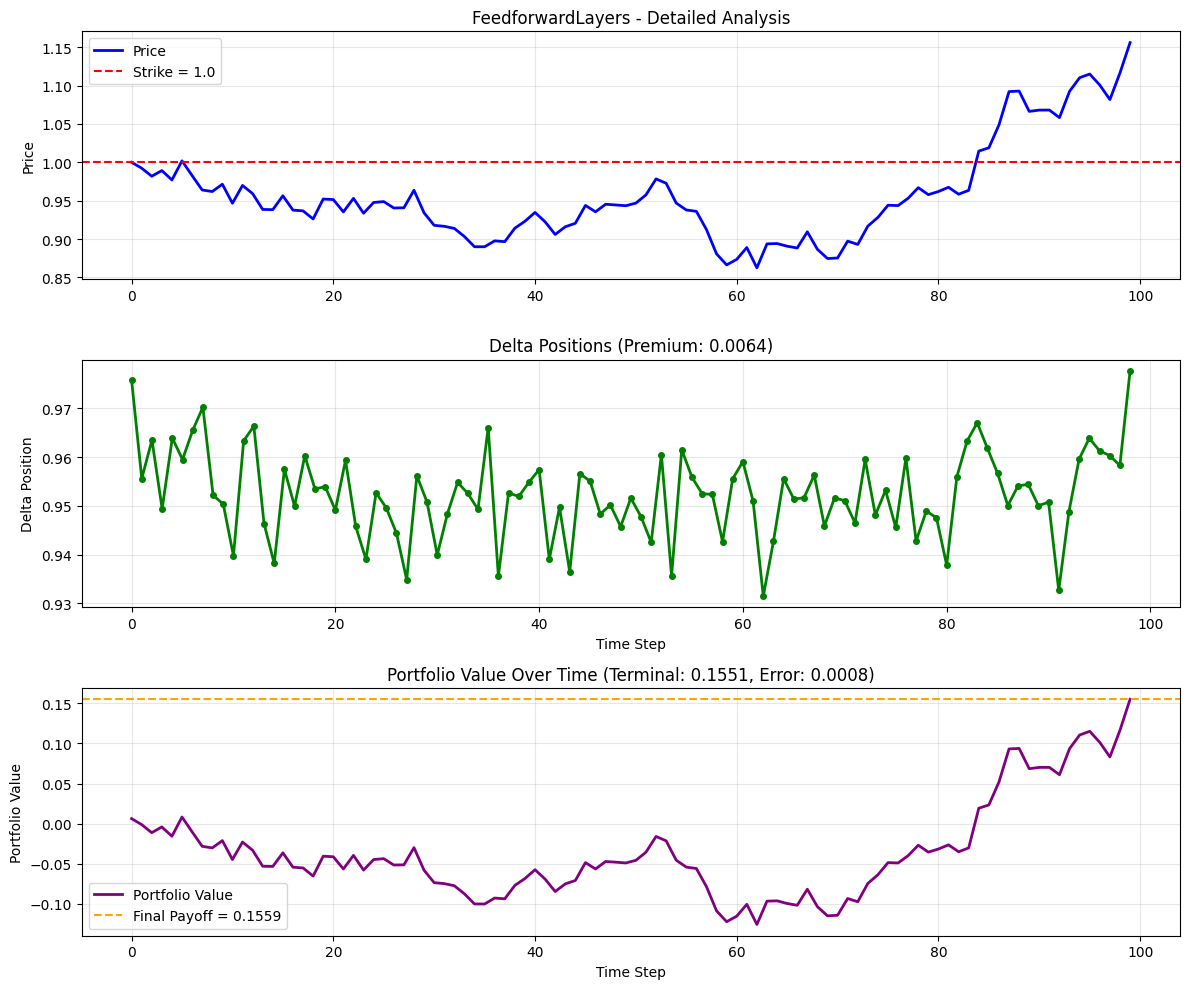

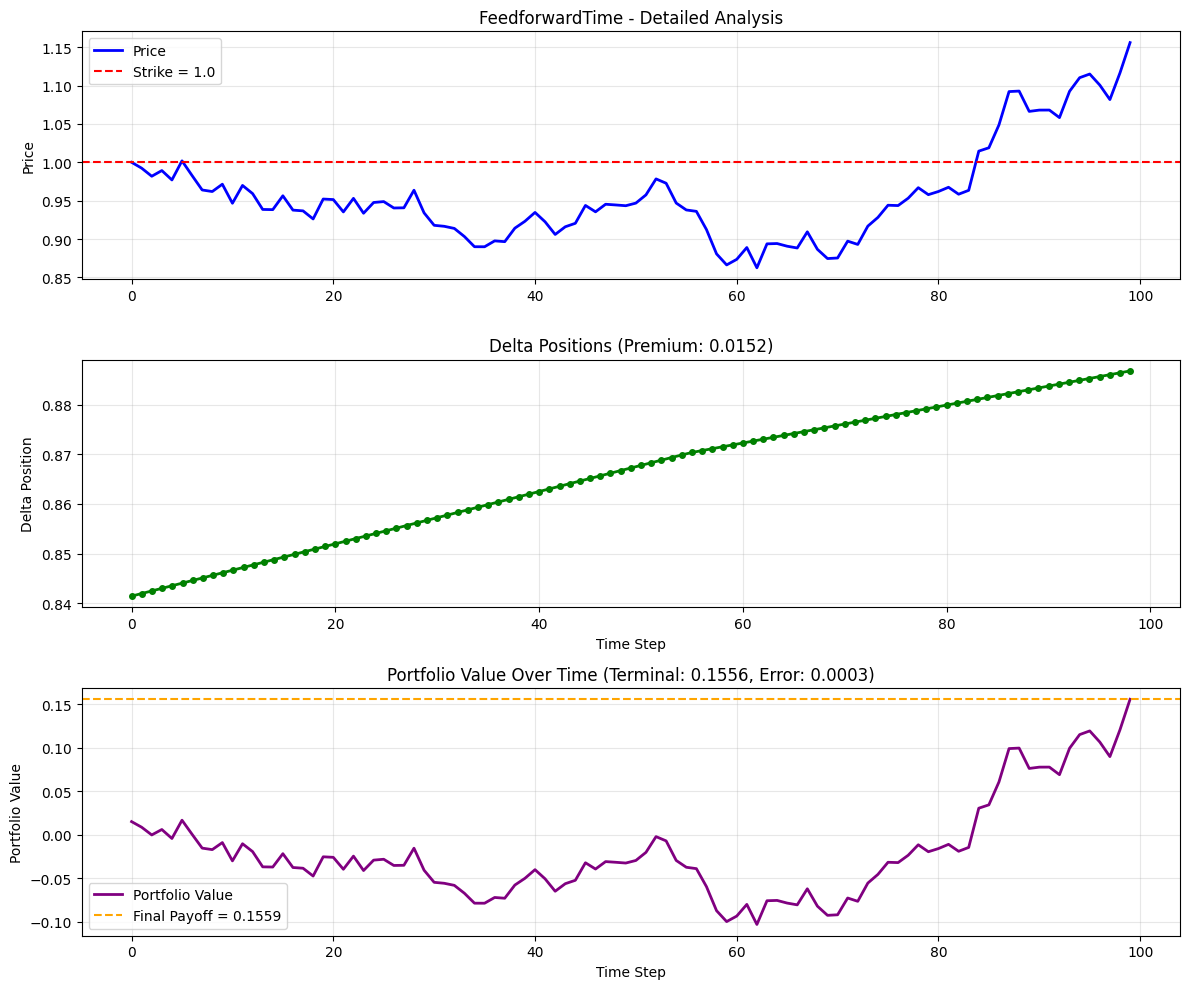

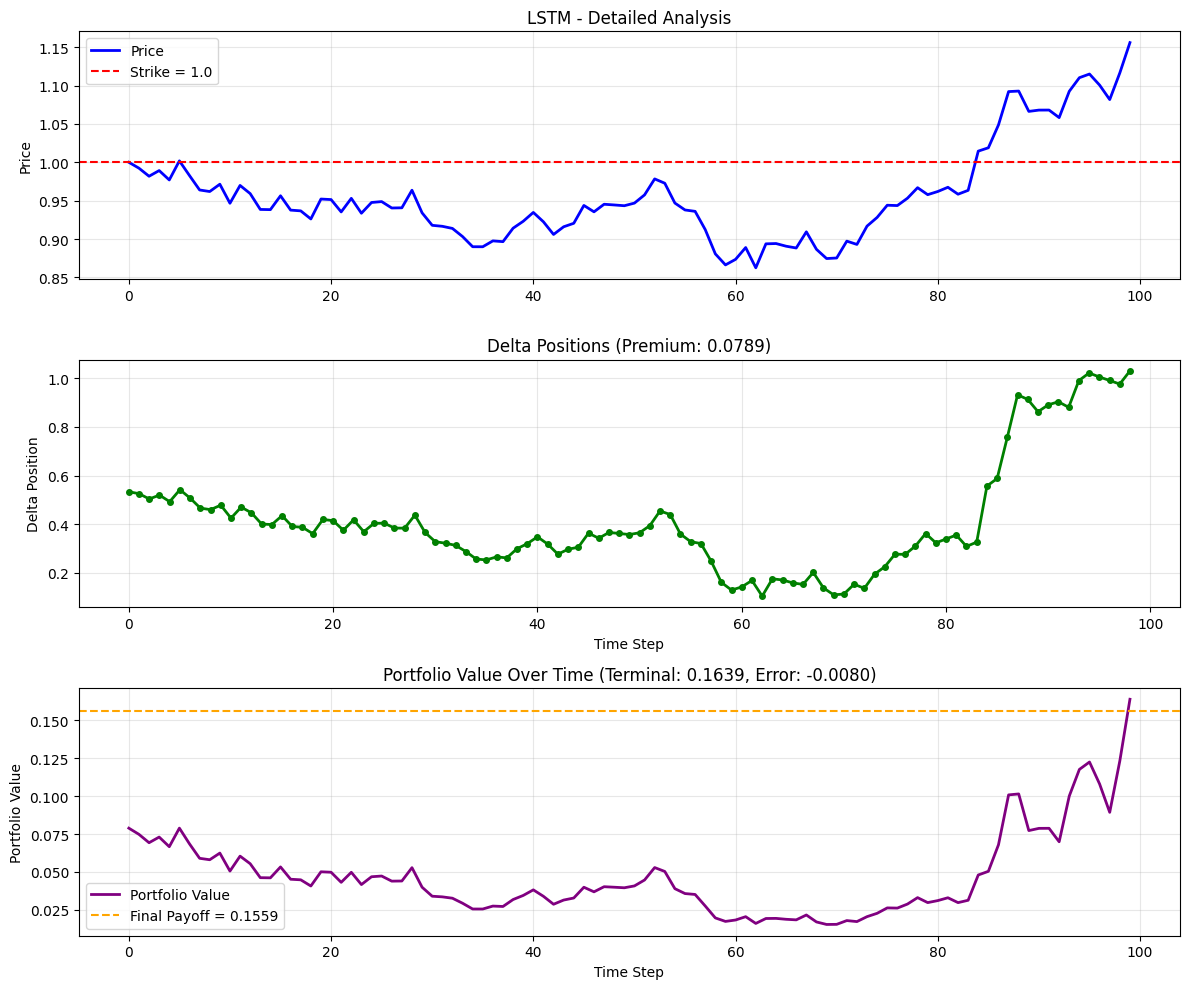

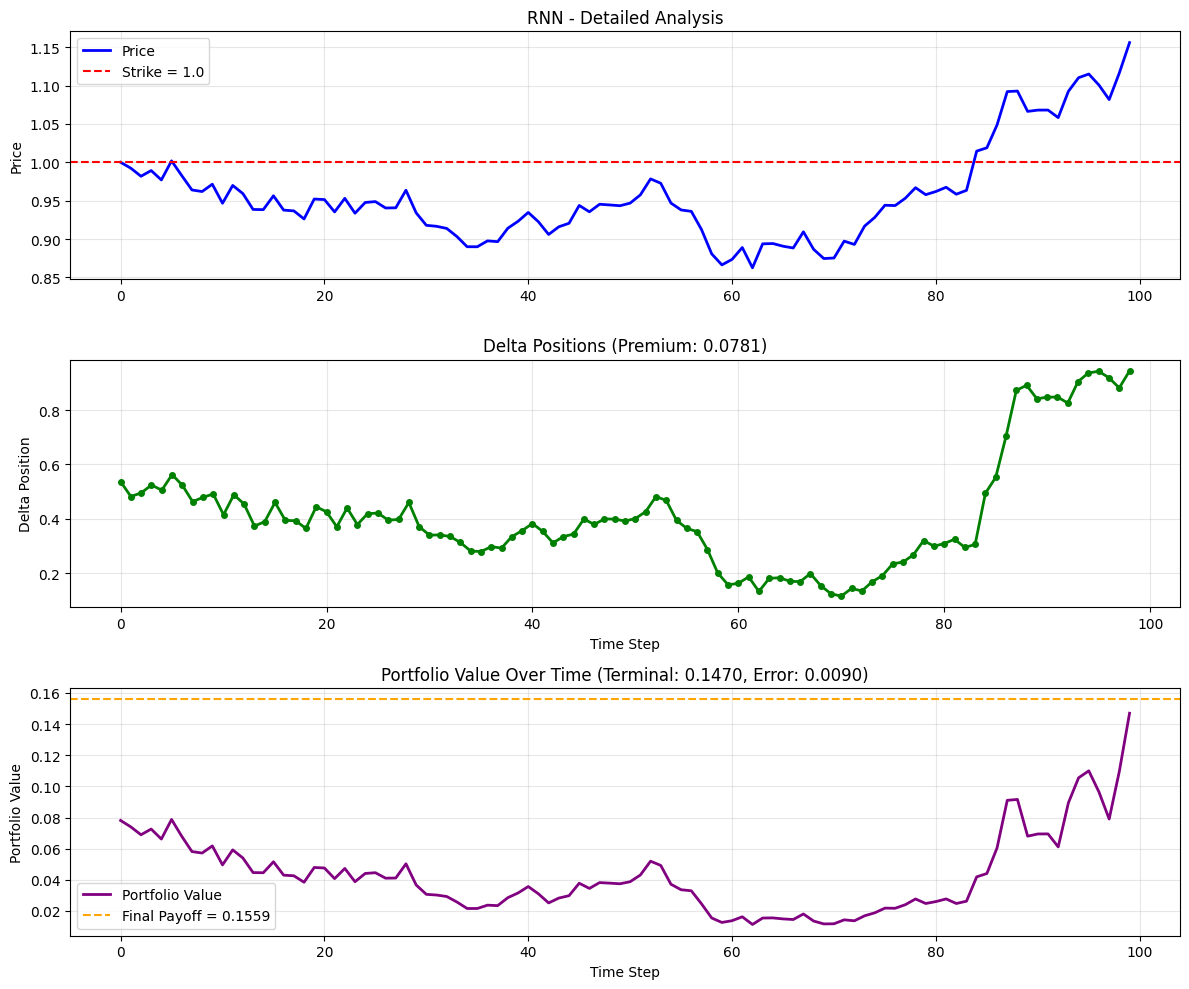

In [9]:
# Detailed analysis: plot price path, deltas, and portfolio value over time
selected_models = ['BlackScholes', 'DeltaGamma', 'LinearRegression', 'XGBoost', 'FeedforwardLayers', 'FeedforwardTime', 'LSTM', 'RNN']
selected_models = [m for m in selected_models if m in evaluation_results and evaluation_results[m] is not None]

sample_idx = 10
sample_prices = test_prices[sample_idx:sample_idx+1]

for name in selected_models:
    model = models[name]
    
    with torch.no_grad():
        deltas = model.forward(sample_prices)
        terminal_value = model.compute_terminal_value(sample_prices, deltas)
        final_price = sample_prices[0, -1]
        payoff = model.compute_payoff(final_price.unsqueeze(0))
    
    prices_np = sample_prices[0].cpu().numpy()
    deltas_np = deltas[0].cpu().numpy()
    premium = evaluation_results[name]['premium']
    
    # Compute portfolio value over time
    portfolio_values = [premium]  # Start with premium
    for t in range(seq_length):
        price_change = prices_np[t+1] - prices_np[t]
        portfolio_values.append(portfolio_values[-1] + deltas_np[t] * price_change)
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Plot 1: Price path
    axes[0].plot(np.arange(seq_length+1), prices_np, 'b-', linewidth=2, label='Price')
    axes[0].axhline(y=strike, color='r', linestyle='--', label=f'Strike = {strike}')
    axes[0].set_ylabel('Price')
    axes[0].set_title(f'{name} - Detailed Analysis')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Delta positions
    axes[1].plot(np.arange(seq_length), deltas_np, 'g-', linewidth=2, marker='o', markersize=4)
    axes[1].set_ylabel('Delta Position')
    axes[1].set_xlabel('Time Step')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_title(f'Delta Positions (Premium: {premium:.4f})')
    
    # Plot 3: Portfolio value over time
    axes[2].plot(np.arange(seq_length+1), portfolio_values, 'purple', linewidth=2, label='Portfolio Value')
    axes[2].axhline(y=payoff.item(), color='orange', linestyle='--', label=f'Final Payoff = {payoff.item():.4f}')
    axes[2].set_ylabel('Portfolio Value')
    axes[2].set_xlabel('Time Step')
    axes[2].set_title(f'Portfolio Value Over Time (Terminal: {terminal_value.item():.4f}, Error: {(payoff - terminal_value).item():.4f})')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Summary

This notebook has:
1. ✅ Generated GBM price paths
2. ✅ Trained all hedging models (deep and non-deep)
3. ✅ Evaluated models on test data
4. ✅ Visualized price paths, delta positions, and premiums
5. ✅ Computed and compared replication errors

Key findings:
- **Premium**: Initial cost of the option
- **Delta Positions**: Hedging positions at each time step
- **Replication Error (X)**: Payoff - Terminal Value (should be close to 0 for good hedgers)
- **MSE of X**: Mean squared error of replication error (lower is better)
